# Set up

In [9]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from collections import Counter
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import nibabel as nib
import nibabel.freesurfer.io as fsio
from nilearn import datasets, plotting
import random
from joblib import Parallel, delayed
import os

In [2]:
random.seed(42)
np.random.seed(42)

In [3]:
rename = pd.read_csv('/Users/baileyng/MIND_models/region_names/col_renames.csv')
rename_dict = dict(zip(rename['datafield_code'], rename['datafield_name']))

weights_dir = '/Users/baileyng/MIND_models/models_elasticnet/elasticnet_weights'

# ElasticNet Analysis Function

In [4]:
#inner parallelized
def elasticnet_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10):
    preprocessor = ColumnTransformer(transformers=[
        # scale continuous features
        ('num', StandardScaler(), continuous_vars),
        # one-hot encode the assessment centre (drop one level to avoid collinearity)
        ('cat', OneHotEncoder(drop='first', sparse=False), categorical_vars),
    ])

    # Cross-validation set-up
    outer_cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    outer_mae, outer_rmse, outer_r2 = [], [], []
    best_params_per_fold = []
    nonzero_predictors = []
    coefs_list = []

    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), start=1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Inner CV
        pipe = make_pipeline(
            preprocessor,
            ElasticNetCV(
                l1_ratio=np.linspace(0.3,0.9,7),
                alphas=np.logspace(-4,1,11),
                cv=10, max_iter=40000, random_state=42,
                n_jobs=-1
            )
        )

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        # --- metrics ---
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        outer_mae.append(mae)
        outer_rmse.append(rmse)
        outer_r2.append(r2)

        # --- store best α & l1_ratio for this fold ---
        est = pipe.named_steps['elasticnetcv']
        best_params_per_fold.append(
            {'alpha': est.alpha_, 'l1_ratio': est.l1_ratio_}
        )

        # --- predictors that survived ---
        coefs = est.coef_
        coefs_list.append(coefs)
        surviving = [col for col, c in zip(X.columns, coefs) if c != 0]
        nonzero_predictors.append(surviving)

        print(f'Fold {fold:02d} • MAE={mae:.3f} • RMSE={rmse:.3f} • R²={r2:.3f} '
            f'• α={est.alpha_:.4g} • l1_ratio={est.l1_ratio_:.2f}')
        

    # Aggregate results
    print('\n=== 10-fold CV summary ===')
    print(f'Mean MAE :  {np.mean(outer_mae):.3f}  ± {np.std(outer_mae):.3f}')
    print(f'Mean RMSE:  {np.mean(outer_rmse):.3f} ± {np.std(outer_rmse):.3f}')
    print(f'Mean R²  :  {np.mean(outer_r2):.3f}  ± {np.std(outer_r2):.3f}')

    # Get feature names after preprocessing
    # First, fit the preprocessor to get the transformed feature names
    preprocessor_fitted = preprocessor.fit(X)

    # Get feature names for each transformer
    num_features = continuous_vars
    cat_features = list(preprocessor_fitted.named_transformers_['cat'].get_feature_names_out(categorical_vars))

    # Combine all feature names in the correct order
    all_feature_names = num_features + cat_features

    # Final refit on all data using mean best parameters
    mean_alpha = np.mean([p['alpha'] for p in best_params_per_fold])
    mean_l1_ratio = np.mean([p['l1_ratio'] for p in best_params_per_fold])

    final_pipe = make_pipeline(
        preprocessor,
        ElasticNet(
            alpha=mean_alpha,
            l1_ratio=mean_l1_ratio,
            max_iter=40000,
            random_state=42
        )
    ).fit(X, y)

    elasticnet = final_pipe.named_steps['elasticnet']

    os.makedirs(weights_dir, exist_ok=True)

    # Create a DataFrame to store the coefficients
    coefs_df = pd.DataFrame({
        'Feature': all_feature_names,
        'Coefficient': elasticnet.coef_
    })

    weights_filename = f'ElasticNet_weights_{data_name}_{target_name}.csv'
    weights_filepath = os.path.join(weights_dir, weights_filename)
    coefs_df.to_csv(weights_filepath, index=False)

    print(f"ElasticNet coefficients saved to: {weights_filepath}")
    print(f"Final model parameters: α={mean_alpha:.4g}, l1_ratio={mean_l1_ratio:.3f}")
    print(f"Number of non-zero coefficients: {np.sum(elasticnet.coef_ != 0)}")

In [7]:
def plot_elasticnet_weights(weights_filepath, data_name, target_name, top_n=50):
    # Load elasticnet coefficients
    coefs_df = pd.read_csv(weights_filepath)
    
    print(f"Loaded ElasticNet coefficients from: {weights_filepath}")
    print(f"Shape: {coefs_df.shape}")
    print(f"Number of non-zero coefficients: {np.sum(coefs_df['Coefficient'] != 0)}")
    
    # Load MIND regions (same as PLS function)
    with open('/Users/baileyng/MIND_models/region_names/MIND_regions.txt', 'r') as f:
        MIND_regions = [line.strip() for line in f.readlines()]
    
    # Filter for MIND regions only and non-zero coefficients
    mind_coefs = []
    for _, row in coefs_df.iterrows():
        feature_name = row['Feature']
        coefficient = row['Coefficient']
        # Only include MIND regions with non-zero coefficients
        if feature_name in MIND_regions and coefficient != 0:
            mind_coefs.append((feature_name, coefficient))
    
    print(f"Found {len(mind_coefs)} non-zero MIND region coefficients")
    
    if len(mind_coefs) == 0:
        print("No non-zero MIND region coefficients found!")
        return
    
    # Create edge list from MIND features
    edge_list = []
    for feature_name, coef in mind_coefs:
        regions = feature_name.split('-')
        if len(regions) == 2:
            region1, region2 = regions
            edge_list.append((region1, region2, coef))
    
    if len(edge_list) == 0:
        print("No valid MIND connectivity edges found!")
        return
    
    # FreeSurfer centroids parsing function (same as PLS)
    def parse_freesurfer_centroids(centroids_path):
        region_to_coord = {}
        with open(centroids_path, 'r') as f:
            for line in f:
                if line.startswith('#') or line.strip() == "":
                    continue
                parts = line.strip().split()
                if len(parts) < 5:
                    continue
                label = parts[1]
                coords = tuple(map(float, parts[2:5]))
                # Convert 'ctx-lh-bankssts' -> 'lh_bankssts'
                match = re.match(r'ctx-(lh|rh)-(.*)', label)
                if match:
                    hemi, region = match.groups()
                    key = f"{hemi}_{region}"
                    region_to_coord[key] = coords
        return region_to_coord

    centroids_file = '/Users/baileyng/MIND_models/centroids.txt'
    region_to_coord = parse_freesurfer_centroids(centroids_file)
    
    # Sort edges by magnitude and take top edges
    edge_list_sorted = sorted(edge_list, key=lambda x: abs(x[2]), reverse=True)
    top_edges = edge_list_sorted[:min(top_n, len(edge_list_sorted))]
    
    # Getting list of nodes and coordinates  
    node_labels = sorted({n for edge in top_edges for n in edge[:2]})
    coords_native = []
    missing = []
    for label in node_labels:
        if label in region_to_coord:
            coords_native.append(region_to_coord[label])
        else:
            coords_native.append((float('nan'), float('nan'), float('nan')))
            missing.append(label)
    coords_native = np.array(coords_native)
    label_to_idx = {lab: i for i, lab in enumerate(node_labels)}
    n_nodes = len(node_labels)

    if missing:
        print(f"WARNING: The following regions were not found in centroids.txt:")
        print(missing)

    # Transform coordinates to MNI space (same as PLS)
    def load_talairach_xfm(xfm_path):
        with open(xfm_path) as f:
            lines = f.readlines()
        start = [i for i, l in enumerate(lines) if 'Linear_Transform' in l][0]
        matrix_lines = lines[start+1:start+4]
        matrix = np.array([
            [float(val.strip(';')) for val in line.strip().split()]
            for line in matrix_lines
        ])
        affine = np.eye(4)
        affine[:3, :4] = matrix
        return affine

    talairach_xfm = '/Applications/freesurfer/subjects/bert/mri/transforms/talairach.xfm'
    affine = load_talairach_xfm(talairach_xfm)
    coords_mni = nib.affines.apply_affine(affine, coords_native)

    # Create adjacency matrix
    adj_matrix = np.zeros((n_nodes, n_nodes))
    for n1, n2, w in top_edges:
        i, j = label_to_idx[n1], label_to_idx[n2]
        adj_matrix[i, j] = w
        adj_matrix[j, i] = w  # For undirected connectome

    # Scale coordinates (same as PLS)
    def scale_coords_to_brain(coords, scale=1.0):
        mean = np.mean(coords, axis=0)
        coords_centered = coords - mean
        coords_scaled = coords_centered * scale
        coords_scaled = coords_scaled + mean
        return coords_scaled

    coords_mni_scaled = scale_coords_to_brain(coords_mni, scale=1.0)

    # Calculate symmetric limits for colorbar
    max_abs_val = np.max(np.abs(adj_matrix))
    
    print(f"Top edge coefficient magnitude: {max_abs_val:.4f}")

    # Plot (same style as PLS)
    fig = plt.figure(figsize=(12, 8))

    display = plotting.plot_connectome(
        adj_matrix,
        coords_mni_scaled,
        edge_threshold=0.0,
        node_color='black',
        node_size=50,
        display_mode='ortho',
        title=f"Top {len(top_edges)} ElasticNet Coefficients (MIND vs {target_name})",
        figure=fig,
        edge_cmap='bwr',
        edge_vmin=-max_abs_val,
        edge_vmax=max_abs_val,
        node_kwargs={'alpha': 0.9}
    )

    sm = plt.cm.ScalarMappable(cmap='bwr', norm=plt.Normalize(vmin=-max_abs_val, vmax=max_abs_val))
    sm.set_array([])
    cbar_ax = fig.add_axes([0.35, 0.15, 0.3, 0.03])  # [left, bottom, width, height]
    cb = plt.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cb.set_label('Coefficient Value (Red = Positive, Blue = Negative)', fontsize=14, labelpad=10)
    cb.ax.tick_params(labelsize=12)

    plt.tight_layout(rect=[0, 0.2, 1, 1])  # Make room for colorbar
    plt.show()

Loaded ElasticNet coefficients from: /Users/baileyng/MIND_models/models_elasticnet/elasticnet_weights/ElasticNet_weights_MIND_GF.csv
Shape: (2282, 2)
Number of non-zero coefficients: 290
Found 287 non-zero MIND region coefficients
Top edge coefficient magnitude: 0.0562


/var/folders/kb/ln31wlhj2hb0n089p20hvk9r0000gn/T/ipykernel_18274/398981521.py:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.2, 1, 1])  # Make room for colorbar


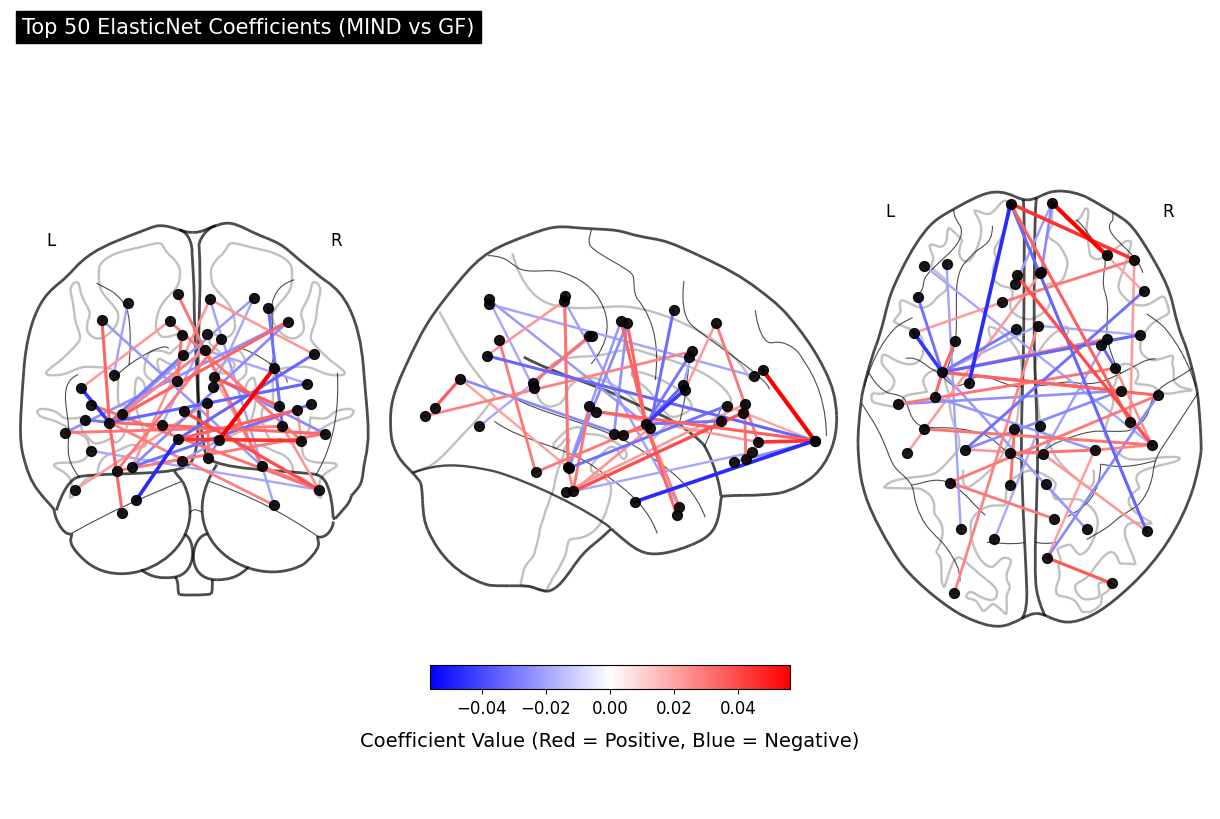

In [10]:
weights_file = '/Users/baileyng/MIND_models/models_elasticnet/elasticnet_weights/ElasticNet_weights_MIND_GF.csv'
plot_elasticnet_weights(weights_file, 'MIND', 'GF', top_n=50)

Loaded ElasticNet coefficients from: /Users/baileyng/MIND_models/models_elasticnet/elasticnet_weights/ElasticNet_weights_MIND_PAL.csv
Shape: (2282, 2)
Number of non-zero coefficients: 187
Found 184 non-zero MIND region coefficients
Top edge coefficient magnitude: 0.0517


/var/folders/kb/ln31wlhj2hb0n089p20hvk9r0000gn/T/ipykernel_18274/398981521.py:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.2, 1, 1])  # Make room for colorbar


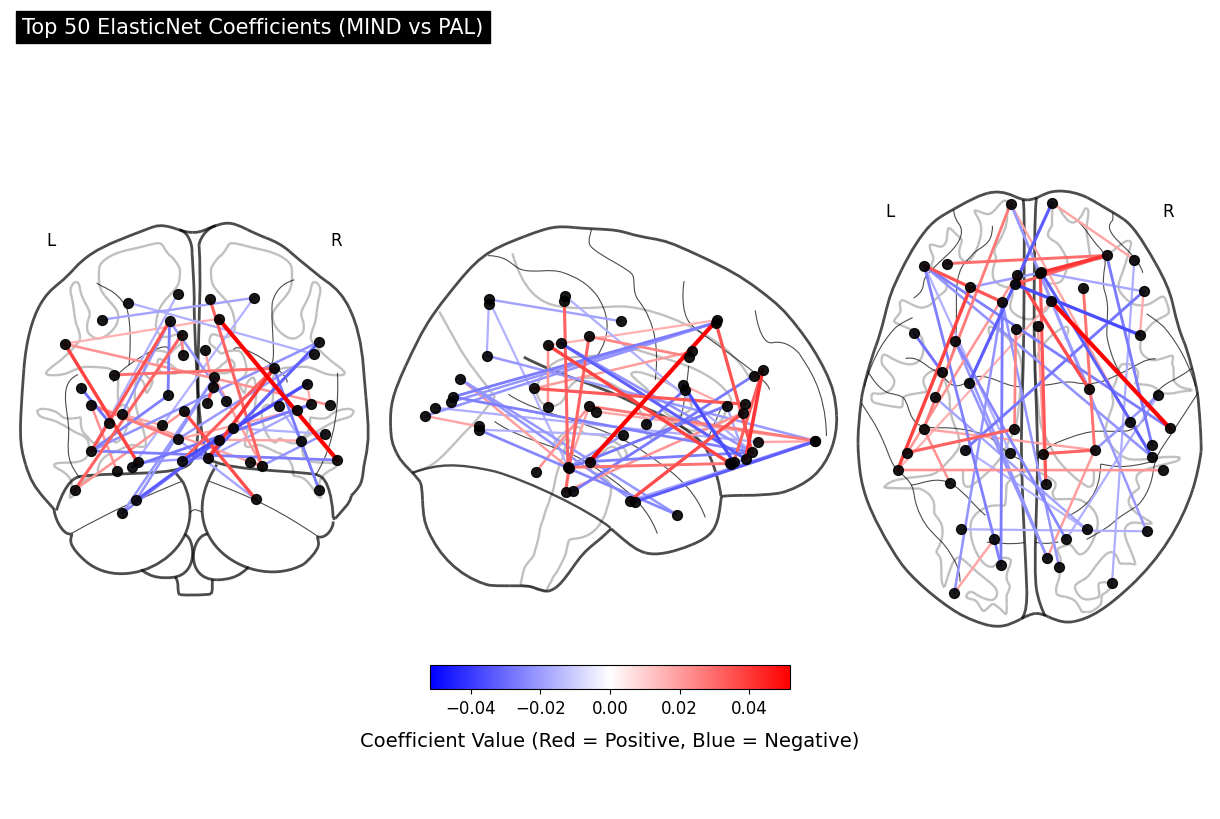

In [11]:
weights_file = '/Users/baileyng/MIND_models/models_elasticnet/elasticnet_weights/ElasticNet_weights_MIND_PAL.csv'
plot_elasticnet_weights(weights_file, 'MIND', 'PAL', top_n=50)

Loaded ElasticNet coefficients from: /Users/baileyng/MIND_models/models_elasticnet/elasticnet_weights/ElasticNet_weights_MIND_DSST.csv
Shape: (2282, 2)
Number of non-zero coefficients: 120
Found 119 non-zero MIND region coefficients
Top edge coefficient magnitude: 0.0986


/var/folders/kb/ln31wlhj2hb0n089p20hvk9r0000gn/T/ipykernel_18274/398981521.py:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.2, 1, 1])  # Make room for colorbar


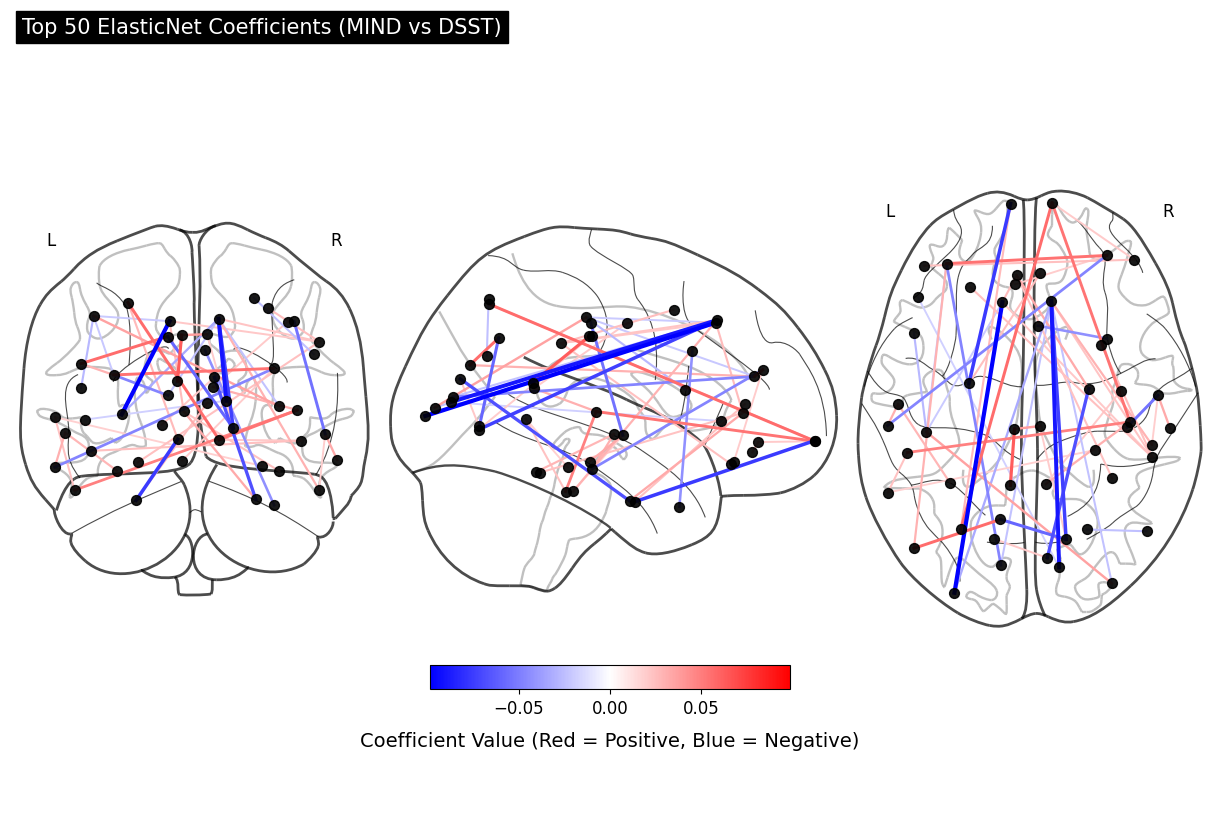

In [12]:
weights_file = '/Users/baileyng/MIND_models/models_elasticnet/elasticnet_weights/ElasticNet_weights_MIND_DSST.csv'
plot_elasticnet_weights(weights_file, 'MIND', 'DSST', top_n=50)

Loaded ElasticNet coefficients from: /Users/baileyng/MIND_models/models_elasticnet/elasticnet_weights/ElasticNet_weights_MIND_TMT.csv
Shape: (2282, 2)
Number of non-zero coefficients: 449
Found 447 non-zero MIND region coefficients
Top edge coefficient magnitude: 5.3567


/var/folders/kb/ln31wlhj2hb0n089p20hvk9r0000gn/T/ipykernel_18274/398981521.py:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.2, 1, 1])  # Make room for colorbar


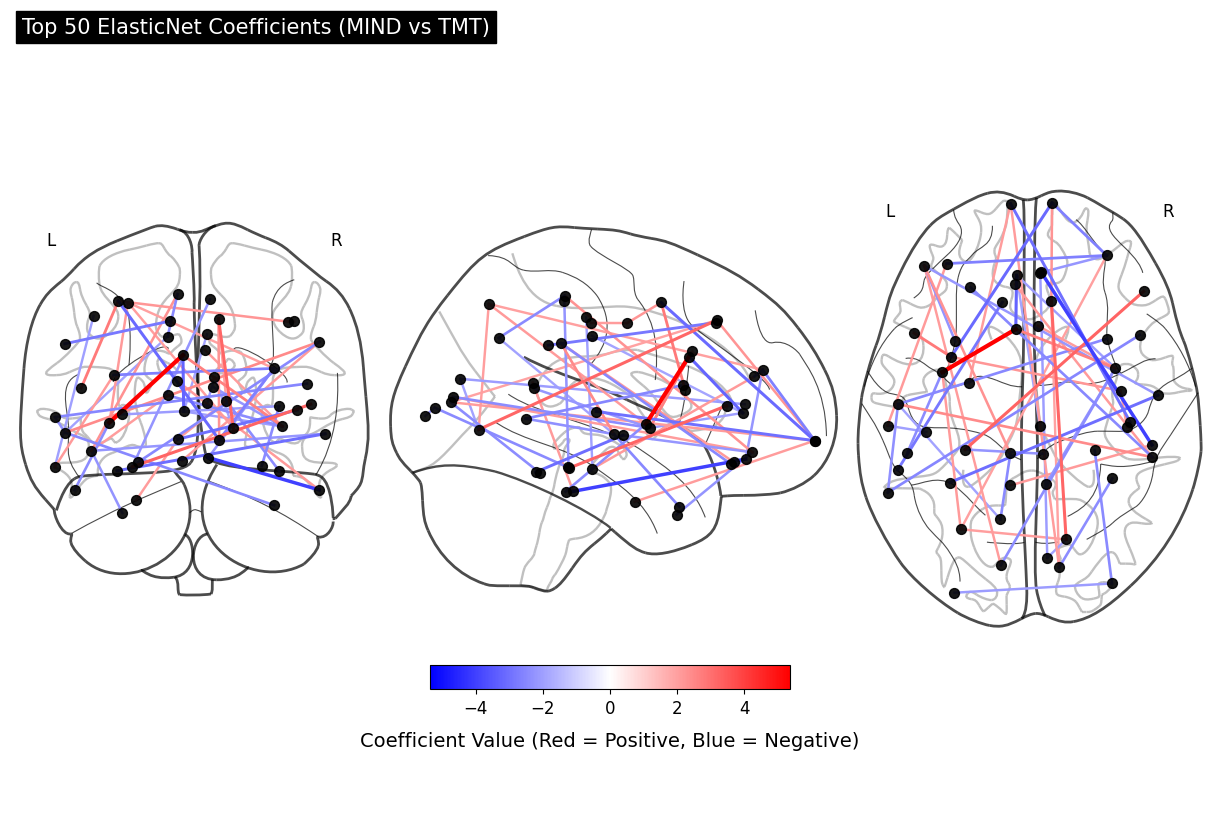

In [13]:
weights_file = '/Users/baileyng/MIND_models/models_elasticnet/elasticnet_weights/ElasticNet_weights_MIND_TMT.csv'
plot_elasticnet_weights(weights_file, 'MIND', 'TMT', top_n=50)

# GF

In [5]:
# Load the dataset
df = pd.read_csv('/Users/baileyng/MIND_data/ukb_cog/ukb_master_GF_no_outliers.csv', index_col=0)
target_name = 'GF'

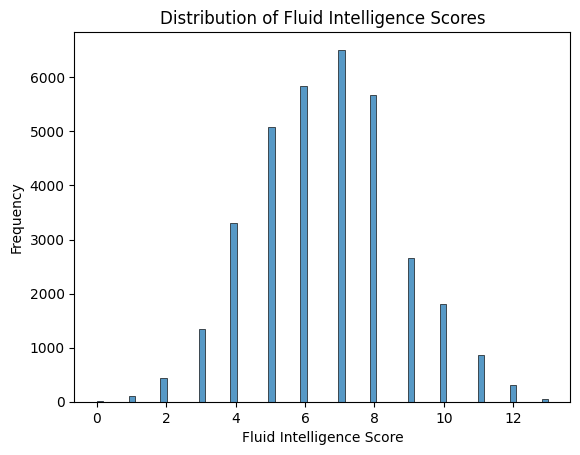

In [6]:
# Histogram of Fluid Intelligence Scores
sns.histplot(df['20016-2.0'])
plt.title('Distribution of Fluid Intelligence Scores')
plt.xlabel('Fluid Intelligence Score')
plt.ylabel('Frequency')
plt.show()

In [28]:
print(len(df))
print(df.shape)

33977
(33977, 2628)


## GF vs. MIND (avg)

In [42]:
data_name = 'MIND_avg'

# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_avg_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['20016-2.0']

print(X.shape)
print(y.shape)

(33977, 71)
(33977,)


In [43]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [44]:
elasticnet_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10)

Fold 01 • MAE=1.621 • RMSE=2.021 • R²=0.029 • α=0.01 • l1_ratio=0.50
Fold 02 • MAE=1.635 • RMSE=2.034 • R²=0.031 • α=0.01 • l1_ratio=0.30
Fold 03 • MAE=1.642 • RMSE=2.043 • R²=0.039 • α=0.01 • l1_ratio=0.40
Fold 04 • MAE=1.653 • RMSE=2.058 • R²=0.033 • α=0.01 • l1_ratio=0.30
Fold 05 • MAE=1.606 • RMSE=2.003 • R²=0.031 • α=0.01 • l1_ratio=0.40
Fold 06 • MAE=1.585 • RMSE=1.977 • R²=0.043 • α=0.01 • l1_ratio=0.40
Fold 07 • MAE=1.616 • RMSE=2.016 • R²=0.033 • α=0.01 • l1_ratio=0.30
Fold 08 • MAE=1.657 • RMSE=2.052 • R²=0.022 • α=0.01 • l1_ratio=0.30
Fold 09 • MAE=1.608 • RMSE=2.002 • R²=0.036 • α=0.01 • l1_ratio=0.30
Fold 10 • MAE=1.629 • RMSE=2.033 • R²=0.035 • α=0.01 • l1_ratio=0.30

=== 10-fold CV summary ===
Mean MAE :  1.625  ± 0.021
Mean RMSE:  2.024 ± 0.024
Mean R²  :  0.033  ± 0.005
ElasticNet coefficients saved to: /Users/baileyng/MIND_models/models_elasticnet/elasticnet_weights/ElasticNet_weights_MIND_avg_GF.csv
Final model parameters: α=0.01, l1_ratio=0.350
Number of non-zero co

## GF vs. CT

In [45]:
data_name = 'CT'

# Set X and y
with open('/Users/baileyng/MIND_models/region_names/CT_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['20016-2.0']

print(X.shape)
print(y.shape)

(33977, 65)
(33977,)


In [46]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [47]:
elasticnet_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10)

Fold 01 • MAE=1.630 • RMSE=2.031 • R²=0.019 • α=0.003162 • l1_ratio=0.80
Fold 02 • MAE=1.643 • RMSE=2.040 • R²=0.026 • α=0.003162 • l1_ratio=0.80
Fold 03 • MAE=1.651 • RMSE=2.056 • R²=0.026 • α=0.003162 • l1_ratio=0.50
Fold 04 • MAE=1.662 • RMSE=2.070 • R²=0.021 • α=0.003162 • l1_ratio=0.50
Fold 05 • MAE=1.605 • RMSE=2.003 • R²=0.031 • α=0.003162 • l1_ratio=0.90
Fold 06 • MAE=1.592 • RMSE=1.987 • R²=0.032 • α=0.003162 • l1_ratio=0.80
Fold 07 • MAE=1.631 • RMSE=2.035 • R²=0.015 • α=0.003162 • l1_ratio=0.80
Fold 08 • MAE=1.653 • RMSE=2.046 • R²=0.028 • α=0.003162 • l1_ratio=0.80
Fold 09 • MAE=1.623 • RMSE=2.015 • R²=0.022 • α=0.003162 • l1_ratio=0.50
Fold 10 • MAE=1.638 • RMSE=2.044 • R²=0.026 • α=0.003162 • l1_ratio=0.70

=== 10-fold CV summary ===
Mean MAE :  1.633  ± 0.021
Mean RMSE:  2.033 ± 0.024
Mean R²  :  0.025  ± 0.005
ElasticNet coefficients saved to: /Users/baileyng/MIND_models/models_elasticnet/elasticnet_weights/ElasticNet_weights_CT_GF.csv
Final model parameters: α=0.003162

## GF vs. FC

In [7]:
data_name = 'FC'

# Set X and y
with open('/Users/baileyng/MIND_models/region_names/FC_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0', '25741-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['20016-2.0']

print(X.shape)
print(y.shape)

(33977, 214)
(33977,)


In [8]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [9]:
elasticnet_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10)

/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 01 • MAE=1.581 • RMSE=1.984 • R²=0.064 • α=0.01 • l1_ratio=0.30


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 02 • MAE=1.599 • RMSE=1.989 • R²=0.074 • α=0.01 • l1_ratio=0.30


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 03 • MAE=1.613 • RMSE=2.018 • R²=0.062 • α=0.01 • l1_ratio=0.30


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 04 • MAE=1.617 • RMSE=2.019 • R²=0.069 • α=0.01 • l1_ratio=0.40


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 05 • MAE=1.573 • RMSE=1.963 • R²=0.069 • α=0.01 • l1_ratio=0.30


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 06 • MAE=1.546 • RMSE=1.930 • R²=0.087 • α=0.01 • l1_ratio=0.30


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 07 • MAE=1.598 • RMSE=1.995 • R²=0.053 • α=0.01 • l1_ratio=0.30


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 08 • MAE=1.603 • RMSE=1.999 • R²=0.072 • α=0.01 • l1_ratio=0.30


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 09 • MAE=1.573 • RMSE=1.965 • R²=0.070 • α=0.01 • l1_ratio=0.30


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 10 • MAE=1.591 • RMSE=1.988 • R²=0.078 • α=0.01 • l1_ratio=0.40

=== 10-fold CV summary ===
Mean MAE :  1.589  ± 0.020
Mean RMSE:  1.985 ± 0.026
Mean R²  :  0.070  ± 0.009


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ElasticNet coefficients saved to: /Users/baileyng/MIND_models/models_elasticnet/elasticnet_weights/ElasticNet_weights_FC_GF.csv
Final model parameters: α=0.01, l1_ratio=0.320
Number of non-zero coefficients: 190


## GF vs. Demographic Data

In [48]:
data_name = 'demo'

# Set X and y
brain_regions = []

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['20016-2.0']

print(X.shape)
print(y.shape)

(33977, 3)
(33977,)


In [49]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [50]:
elasticnet_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10)

Fold 01 • MAE=1.634 • RMSE=2.040 • R²=0.010 • α=0.0003162 • l1_ratio=0.30
Fold 02 • MAE=1.654 • RMSE=2.051 • R²=0.015 • α=0.0003162 • l1_ratio=0.30
Fold 03 • MAE=1.666 • RMSE=2.072 • R²=0.012 • α=0.0003162 • l1_ratio=0.30
Fold 04 • MAE=1.670 • RMSE=2.076 • R²=0.015 • α=0.0003162 • l1_ratio=0.30
Fold 05 • MAE=1.614 • RMSE=2.015 • R²=0.019 • α=0.0003162 • l1_ratio=0.30
Fold 06 • MAE=1.601 • RMSE=1.998 • R²=0.022 • α=0.0003162 • l1_ratio=0.30
Fold 07 • MAE=1.642 • RMSE=2.044 • R²=0.006 • α=0.0003162 • l1_ratio=0.30
Fold 08 • MAE=1.670 • RMSE=2.062 • R²=0.012 • α=0.0003162 • l1_ratio=0.30
Fold 09 • MAE=1.631 • RMSE=2.023 • R²=0.015 • α=0.001 • l1_ratio=0.30
Fold 10 • MAE=1.652 • RMSE=2.054 • R²=0.016 • α=0.0003162 • l1_ratio=0.30

=== 10-fold CV summary ===
Mean MAE :  1.643  ± 0.022
Mean RMSE:  2.044 ± 0.024
Mean R²  :  0.014  ± 0.004
ElasticNet coefficients saved to: /Users/baileyng/MIND_models/models_elasticnet/elasticnet_weights/ElasticNet_weights_demo_GF.csv
Final model parameters: α=

# PAL

In [10]:
# Load the dataset
df = pd.read_csv('/Users/baileyng/MIND_data/ukb_cog/ukb_master_PAL_no_outliers.csv', index_col=0)
target_name = 'PAL'

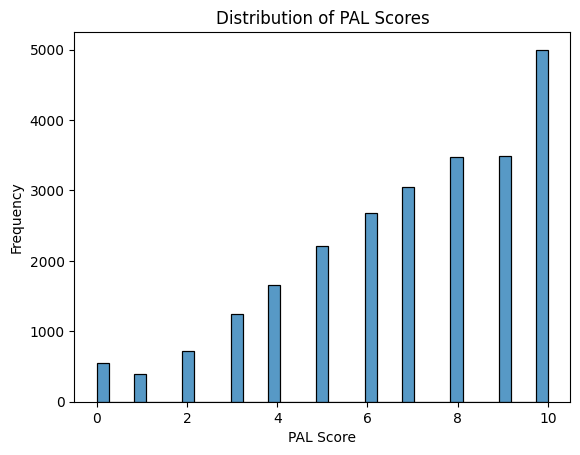

In [11]:
# Histogram of PAL Scores
sns.histplot(df['20197-2.0'])
plt.title('Distribution of PAL Scores')
plt.xlabel('PAL Score')
plt.ylabel('Frequency')
plt.show()

In [65]:
print(len(df))
print(df.shape)

24492
(24492, 2628)


### PAL vs. MIND (avg)

In [57]:
data_name = 'MIND_avg'

# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_avg_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['20197-2.0']

print(X.shape)
print(y.shape)

(24492, 71)
(24492,)


In [58]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [59]:
elasticnet_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10)

Fold 01 • MAE=2.078 • RMSE=2.538 • R²=0.065 • α=0.01 • l1_ratio=0.60
Fold 02 • MAE=2.105 • RMSE=2.552 • R²=0.046 • α=0.01 • l1_ratio=0.60
Fold 03 • MAE=2.096 • RMSE=2.582 • R²=0.063 • α=0.01 • l1_ratio=0.50
Fold 04 • MAE=2.071 • RMSE=2.532 • R²=0.060 • α=0.01 • l1_ratio=0.50
Fold 05 • MAE=2.041 • RMSE=2.474 • R²=0.055 • α=0.01 • l1_ratio=0.60
Fold 06 • MAE=2.107 • RMSE=2.560 • R²=0.079 • α=0.01 • l1_ratio=0.70
Fold 07 • MAE=2.089 • RMSE=2.538 • R²=0.062 • α=0.01 • l1_ratio=0.60
Fold 08 • MAE=2.069 • RMSE=2.534 • R²=0.066 • α=0.01 • l1_ratio=0.50
Fold 09 • MAE=2.083 • RMSE=2.554 • R²=0.066 • α=0.01 • l1_ratio=0.50
Fold 10 • MAE=2.072 • RMSE=2.541 • R²=0.048 • α=0.01 • l1_ratio=0.70

=== 10-fold CV summary ===
Mean MAE :  2.081  ± 0.019
Mean RMSE:  2.541 ± 0.026
Mean R²  :  0.061  ± 0.009
ElasticNet coefficients saved to: /Users/baileyng/MIND_models/models_elasticnet/elasticnet_weights/ElasticNet_weights_MIND_avg_PAL.csv
Final model parameters: α=0.01, l1_ratio=0.580
Number of non-zero c

### PAL vs. CT

In [66]:
data_name = 'CT'

# Set X and y
with open('/Users/baileyng/MIND_models/region_names/CT_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['20197-2.0']

print(X.shape)
print(y.shape)

(24492, 65)
(24492,)


In [67]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [68]:
elasticnet_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10)

Fold 01 • MAE=2.084 • RMSE=2.538 • R²=0.065 • α=0.01 • l1_ratio=0.90
Fold 02 • MAE=2.104 • RMSE=2.553 • R²=0.045 • α=0.01 • l1_ratio=0.90
Fold 03 • MAE=2.097 • RMSE=2.582 • R²=0.063 • α=0.01 • l1_ratio=0.80
Fold 04 • MAE=2.067 • RMSE=2.532 • R²=0.060 • α=0.01 • l1_ratio=0.80
Fold 05 • MAE=2.042 • RMSE=2.473 • R²=0.056 • α=0.01 • l1_ratio=0.70
Fold 06 • MAE=2.111 • RMSE=2.566 • R²=0.075 • α=0.01 • l1_ratio=0.90
Fold 07 • MAE=2.089 • RMSE=2.538 • R²=0.062 • α=0.01 • l1_ratio=0.70
Fold 08 • MAE=2.075 • RMSE=2.540 • R²=0.062 • α=0.01 • l1_ratio=0.80
Fold 09 • MAE=2.086 • RMSE=2.554 • R²=0.066 • α=0.01 • l1_ratio=0.80
Fold 10 • MAE=2.075 • RMSE=2.539 • R²=0.049 • α=0.01 • l1_ratio=0.70

=== 10-fold CV summary ===
Mean MAE :  2.083  ± 0.019
Mean RMSE:  2.542 ± 0.027
Mean R²  :  0.060  ± 0.008
ElasticNet coefficients saved to: /Users/baileyng/MIND_models/models_elasticnet/elasticnet_weights/ElasticNet_weights_CT_PAL.csv
Final model parameters: α=0.01, l1_ratio=0.800
Number of non-zero coeffic

### PAL vs. FC

In [12]:
data_name = 'FC'

# Set X and y
with open('/Users/baileyng/MIND_models/region_names/FC_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0', '25741-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['20197-2.0']

print(X.shape)
print(y.shape)

(24492, 214)
(24492,)


In [13]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [14]:
elasticnet_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10)

/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 01 • MAE=2.040 • RMSE=2.501 • R²=0.092 • α=0.01 • l1_ratio=0.90


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 02 • MAE=2.047 • RMSE=2.499 • R²=0.085 • α=0.01 • l1_ratio=0.90


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 03 • MAE=2.052 • RMSE=2.536 • R²=0.096 • α=0.01 • l1_ratio=0.80


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 04 • MAE=2.035 • RMSE=2.496 • R²=0.087 • α=0.01 • l1_ratio=0.90


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 05 • MAE=1.995 • RMSE=2.421 • R²=0.095 • α=0.01 • l1_ratio=0.80


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 06 • MAE=2.054 • RMSE=2.520 • R²=0.108 • α=0.01 • l1_ratio=0.80


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 07 • MAE=2.033 • RMSE=2.484 • R²=0.101 • α=0.01 • l1_ratio=0.80


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 08 • MAE=2.033 • RMSE=2.496 • R²=0.094 • α=0.01 • l1_ratio=0.80


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 09 • MAE=2.040 • RMSE=2.515 • R²=0.095 • α=0.01 • l1_ratio=0.90


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 10 • MAE=2.020 • RMSE=2.484 • R²=0.091 • α=0.01 • l1_ratio=0.90

=== 10-fold CV summary ===
Mean MAE :  2.035  ± 0.016
Mean RMSE:  2.495 ± 0.029
Mean R²  :  0.094  ± 0.006


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ElasticNet coefficients saved to: /Users/baileyng/MIND_models/models_elasticnet/elasticnet_weights/ElasticNet_weights_FC_PAL.csv
Final model parameters: α=0.01, l1_ratio=0.850
Number of non-zero coefficients: 163


## PAL vs. Demographic Data

In [69]:
data_name = 'demo'

# Set X and y
brain_regions = []

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['20197-2.0']

print(X.shape)
print(y.shape)

(24492, 3)
(24492,)


In [70]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [71]:
elasticnet_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10)

Fold 01 • MAE=2.088 • RMSE=2.546 • R²=0.059 • α=0.001 • l1_ratio=0.30
Fold 02 • MAE=2.105 • RMSE=2.556 • R²=0.043 • α=0.001 • l1_ratio=0.30
Fold 03 • MAE=2.101 • RMSE=2.587 • R²=0.059 • α=0.001 • l1_ratio=0.30
Fold 04 • MAE=2.074 • RMSE=2.537 • R²=0.056 • α=0.001 • l1_ratio=0.30
Fold 05 • MAE=2.044 • RMSE=2.473 • R²=0.056 • α=0.001 • l1_ratio=0.30
Fold 06 • MAE=2.114 • RMSE=2.572 • R²=0.071 • α=0.001 • l1_ratio=0.30
Fold 07 • MAE=2.092 • RMSE=2.544 • R²=0.058 • α=0.001 • l1_ratio=0.30
Fold 08 • MAE=2.069 • RMSE=2.536 • R²=0.065 • α=0.001 • l1_ratio=0.30
Fold 09 • MAE=2.086 • RMSE=2.557 • R²=0.064 • α=0.001 • l1_ratio=0.30
Fold 10 • MAE=2.075 • RMSE=2.543 • R²=0.047 • α=0.001 • l1_ratio=0.30

=== 10-fold CV summary ===
Mean MAE :  2.085  ± 0.019
Mean RMSE:  2.545 ± 0.029
Mean R²  :  0.058  ± 0.008
ElasticNet coefficients saved to: /Users/baileyng/MIND_models/models_elasticnet/elasticnet_weights/ElasticNet_weights_demo_PAL.csv
Final model parameters: α=0.001, l1_ratio=0.300
Number of non

# DSST

In [15]:
# Load the dataset
df = pd.read_csv('/Users/baileyng/MIND_data/ukb_cog/ukb_master_DSST_no_outliers.csv', index_col=0)
target_name = 'DSST'

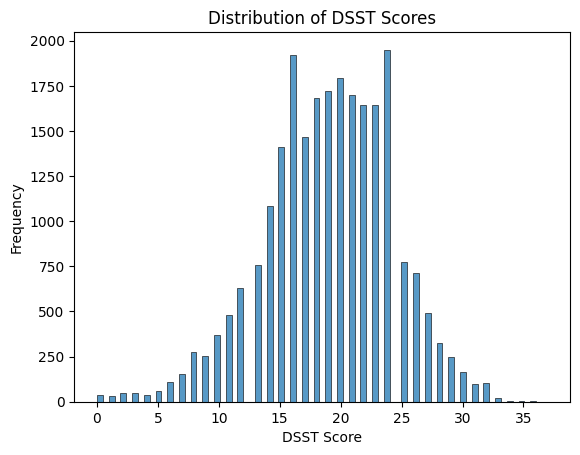

In [16]:
# Histogram of DSST Scores
sns.histplot(df['23324-2.0'])
plt.title('Distribution of DSST Scores')
plt.xlabel('DSST Score')
plt.ylabel('Frequency')
plt.show()

In [74]:
print(len(df))
print(df.shape)

24275
(24275, 2628)


### DSST vs. MIND (avg)

In [75]:
data_name = 'MIND_avg'

# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_avg_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['23324-2.0']

print(X.shape)
print(y.shape)

(24275, 71)
(24275,)


In [76]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [77]:
elasticnet_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10)

Fold 01 • MAE=3.703 • RMSE=4.711 • R²=0.193 • α=0.03162 • l1_ratio=0.60
Fold 02 • MAE=3.802 • RMSE=4.843 • R²=0.208 • α=0.03162 • l1_ratio=0.70
Fold 03 • MAE=3.718 • RMSE=4.707 • R²=0.202 • α=0.03162 • l1_ratio=0.70
Fold 04 • MAE=3.660 • RMSE=4.611 • R²=0.164 • α=0.03162 • l1_ratio=0.70
Fold 05 • MAE=3.777 • RMSE=4.812 • R²=0.182 • α=0.03162 • l1_ratio=0.50
Fold 06 • MAE=3.704 • RMSE=4.738 • R²=0.195 • α=0.03162 • l1_ratio=0.80
Fold 07 • MAE=3.735 • RMSE=4.751 • R²=0.189 • α=0.03162 • l1_ratio=0.60
Fold 08 • MAE=3.710 • RMSE=4.737 • R²=0.184 • α=0.03162 • l1_ratio=0.60
Fold 09 • MAE=3.644 • RMSE=4.638 • R²=0.189 • α=0.03162 • l1_ratio=0.70
Fold 10 • MAE=3.644 • RMSE=4.595 • R²=0.203 • α=0.03162 • l1_ratio=0.70

=== 10-fold CV summary ===
Mean MAE :  3.710  ± 0.050
Mean RMSE:  4.714 ± 0.077
Mean R²  :  0.191  ± 0.012
ElasticNet coefficients saved to: /Users/baileyng/MIND_models/models_elasticnet/elasticnet_weights/ElasticNet_weights_MIND_avg_DSST.csv
Final model parameters: α=0.03162, l

### DSST vs. CT

In [78]:
data_name = 'CT'

# Set X and y
with open('/Users/baileyng/MIND_models/region_names/CT_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['23324-2.0']

print(X.shape)
print(y.shape)

(24275, 65)
(24275,)


In [79]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [80]:
elasticnet_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10)

Fold 01 • MAE=3.711 • RMSE=4.710 • R²=0.193 • α=0.03162 • l1_ratio=0.30
Fold 02 • MAE=3.805 • RMSE=4.840 • R²=0.209 • α=0.03162 • l1_ratio=0.40
Fold 03 • MAE=3.720 • RMSE=4.717 • R²=0.198 • α=0.03162 • l1_ratio=0.70
Fold 04 • MAE=3.656 • RMSE=4.607 • R²=0.165 • α=0.03162 • l1_ratio=0.60
Fold 05 • MAE=3.791 • RMSE=4.831 • R²=0.176 • α=0.03162 • l1_ratio=0.30
Fold 06 • MAE=3.702 • RMSE=4.728 • R²=0.199 • α=0.03162 • l1_ratio=0.50
Fold 07 • MAE=3.745 • RMSE=4.772 • R²=0.182 • α=0.03162 • l1_ratio=0.60
Fold 08 • MAE=3.718 • RMSE=4.748 • R²=0.180 • α=0.03162 • l1_ratio=0.50
Fold 09 • MAE=3.644 • RMSE=4.640 • R²=0.188 • α=0.03162 • l1_ratio=0.60
Fold 10 • MAE=3.649 • RMSE=4.608 • R²=0.199 • α=0.03162 • l1_ratio=0.30

=== 10-fold CV summary ===
Mean MAE :  3.714  ± 0.053
Mean RMSE:  4.720 ± 0.079
Mean R²  :  0.189  ± 0.012
ElasticNet coefficients saved to: /Users/baileyng/MIND_models/models_elasticnet/elasticnet_weights/ElasticNet_weights_CT_DSST.csv
Final model parameters: α=0.03162, l1_rati

### DSST vs. FC

In [17]:
data_name = 'FC'

# Set X and y
with open('/Users/baileyng/MIND_models/region_names/FC_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0', '25741-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['23324-2.0']

print(X.shape)
print(y.shape)

(24275, 214)
(24275,)


In [18]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [19]:
elasticnet_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10)

/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 01 • MAE=3.646 • RMSE=4.655 • R²=0.212 • α=0.03162 • l1_ratio=0.60


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 02 • MAE=3.765 • RMSE=4.805 • R²=0.220 • α=0.03162 • l1_ratio=0.60


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 03 • MAE=3.693 • RMSE=4.663 • R²=0.216 • α=0.03162 • l1_ratio=0.60


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 04 • MAE=3.640 • RMSE=4.601 • R²=0.167 • α=0.03162 • l1_ratio=0.80


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 05 • MAE=3.770 • RMSE=4.790 • R²=0.190 • α=0.03162 • l1_ratio=0.70


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 06 • MAE=3.667 • RMSE=4.686 • R²=0.212 • α=0.03162 • l1_ratio=0.70


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 07 • MAE=3.703 • RMSE=4.707 • R²=0.204 • α=0.03162 • l1_ratio=0.60


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 08 • MAE=3.674 • RMSE=4.714 • R²=0.192 • α=0.03162 • l1_ratio=0.60


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 09 • MAE=3.629 • RMSE=4.613 • R²=0.197 • α=0.03162 • l1_ratio=0.80


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 10 • MAE=3.615 • RMSE=4.560 • R²=0.215 • α=0.03162 • l1_ratio=0.60

=== 10-fold CV summary ===
Mean MAE :  3.680  ± 0.051
Mean RMSE:  4.679 ± 0.075
Mean R²  :  0.203  ± 0.016


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ElasticNet coefficients saved to: /Users/baileyng/MIND_models/models_elasticnet/elasticnet_weights/ElasticNet_weights_FC_DSST.csv
Final model parameters: α=0.03162, l1_ratio=0.660
Number of non-zero coefficients: 132


## DSST vs. Demographic Data

In [81]:
data_name = 'demo'

# Set X and y
brain_regions = []

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['23324-2.0']

print(X.shape)
print(y.shape)

(24275, 3)
(24275,)


In [82]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [83]:
elasticnet_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10)

Fold 01 • MAE=3.725 • RMSE=4.734 • R²=0.185 • α=0.01 • l1_ratio=0.90
Fold 02 • MAE=3.811 • RMSE=4.853 • R²=0.205 • α=0.01 • l1_ratio=0.80
Fold 03 • MAE=3.723 • RMSE=4.723 • R²=0.196 • α=0.01 • l1_ratio=0.90
Fold 04 • MAE=3.674 • RMSE=4.630 • R²=0.157 • α=0.01 • l1_ratio=0.90
Fold 05 • MAE=3.798 • RMSE=4.849 • R²=0.170 • α=0.01 • l1_ratio=0.80
Fold 06 • MAE=3.716 • RMSE=4.749 • R²=0.191 • α=0.01 • l1_ratio=0.90
Fold 07 • MAE=3.761 • RMSE=4.785 • R²=0.178 • α=0.01 • l1_ratio=0.90
Fold 08 • MAE=3.730 • RMSE=4.774 • R²=0.171 • α=0.01 • l1_ratio=0.90
Fold 09 • MAE=3.658 • RMSE=4.660 • R²=0.181 • α=0.01 • l1_ratio=0.90
Fold 10 • MAE=3.666 • RMSE=4.622 • R²=0.194 • α=0.01 • l1_ratio=0.90

=== 10-fold CV summary ===
Mean MAE :  3.726  ± 0.050
Mean RMSE:  4.738 ± 0.078
Mean R²  :  0.183  ± 0.014
ElasticNet coefficients saved to: /Users/baileyng/MIND_models/models_elasticnet/elasticnet_weights/ElasticNet_weights_demo_DSST.csv
Final model parameters: α=0.01, l1_ratio=0.880
Number of non-zero coef

# TMT

In [29]:
# Load the dataset
df = pd.read_csv('/Users/baileyng/MIND_data/ukb_cog/ukb_master_TMT_no_outliers.csv', index_col=0)
target_name = 'TMT'

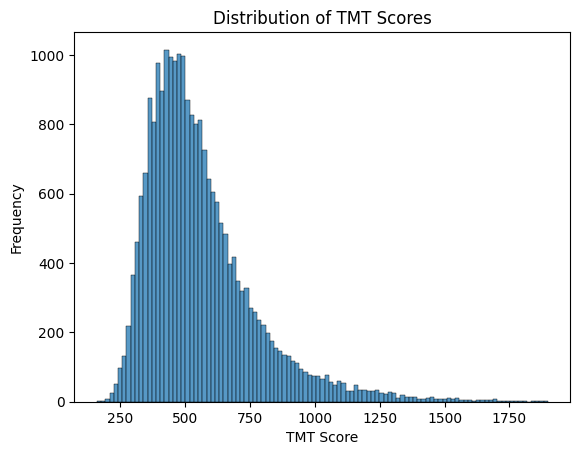

In [30]:
# Histogram of TMT Scores
sns.histplot(df['trailmaking_score'])
plt.title('Distribution of TMT Scores')
plt.xlabel('TMT Score')
plt.ylabel('Frequency')
plt.show()

In [31]:
print(len(df))
print(df.shape)

23362
(23362, 2628)


### TMT vs. MIND (avg)

In [87]:
data_name = 'MIND_avg'

# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_avg_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['trailmaking_score']

print(X.shape)
print(y.shape)

(23362, 71)
(23362,)


In [88]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [89]:
elasticnet_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10)

Fold 01 • MAE=152.210 • RMSE=204.603 • R²=0.099 • α=0.3162 • l1_ratio=0.90
Fold 02 • MAE=142.814 • RMSE=190.768 • R²=0.137 • α=0.3162 • l1_ratio=0.90
Fold 03 • MAE=144.848 • RMSE=197.373 • R²=0.122 • α=0.3162 • l1_ratio=0.90
Fold 04 • MAE=142.602 • RMSE=197.139 • R²=0.136 • α=0.3162 • l1_ratio=0.90
Fold 05 • MAE=140.551 • RMSE=190.637 • R²=0.134 • α=0.3162 • l1_ratio=0.90
Fold 06 • MAE=144.094 • RMSE=200.963 • R²=0.127 • α=0.3162 • l1_ratio=0.90
Fold 07 • MAE=144.158 • RMSE=195.381 • R²=0.135 • α=0.3162 • l1_ratio=0.90
Fold 08 • MAE=146.190 • RMSE=203.608 • R²=0.146 • α=0.3162 • l1_ratio=0.90
Fold 09 • MAE=147.517 • RMSE=203.661 • R²=0.125 • α=0.3162 • l1_ratio=0.90
Fold 10 • MAE=147.100 • RMSE=202.271 • R²=0.153 • α=0.3162 • l1_ratio=0.90

=== 10-fold CV summary ===
Mean MAE :  145.208  ± 3.092
Mean RMSE:  198.640 ± 4.945
Mean R²  :  0.131  ± 0.014
ElasticNet coefficients saved to: /Users/baileyng/MIND_models/models_elasticnet/elasticnet_weights/ElasticNet_weights_MIND_avg_TMT.csv
Fin

### TMT vs. CT

In [90]:
data_name = 'CT'

# Set X and y
with open('/Users/baileyng/MIND_models/region_names/CT_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['trailmaking_score']

print(X.shape)
print(y.shape)

(23362, 65)
(23362,)


In [91]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [92]:
elasticnet_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10)

Fold 01 • MAE=152.063 • RMSE=204.227 • R²=0.103 • α=0.3162 • l1_ratio=0.90
Fold 02 • MAE=142.561 • RMSE=190.925 • R²=0.136 • α=0.3162 • l1_ratio=0.90
Fold 03 • MAE=145.155 • RMSE=197.470 • R²=0.121 • α=0.3162 • l1_ratio=0.90
Fold 04 • MAE=141.839 • RMSE=197.503 • R²=0.133 • α=0.3162 • l1_ratio=0.90
Fold 05 • MAE=141.062 • RMSE=191.113 • R²=0.129 • α=0.3162 • l1_ratio=0.90
Fold 06 • MAE=145.164 • RMSE=201.477 • R²=0.123 • α=0.3162 • l1_ratio=0.90
Fold 07 • MAE=144.961 • RMSE=195.621 • R²=0.133 • α=0.3162 • l1_ratio=0.90
Fold 08 • MAE=147.477 • RMSE=204.930 • R²=0.135 • α=0.3162 • l1_ratio=0.90
Fold 09 • MAE=147.918 • RMSE=203.846 • R²=0.124 • α=0.3162 • l1_ratio=0.90
Fold 10 • MAE=148.032 • RMSE=203.024 • R²=0.146 • α=0.3162 • l1_ratio=0.90

=== 10-fold CV summary ===
Mean MAE :  145.623  ± 3.183
Mean RMSE:  199.014 ± 5.017
Mean R²  :  0.128  ± 0.011
ElasticNet coefficients saved to: /Users/baileyng/MIND_models/models_elasticnet/elasticnet_weights/ElasticNet_weights_CT_TMT.csv
Final mod

### TMT vs. FC

In [32]:
data_name = 'FC'

# Set X and y
with open('/Users/baileyng/MIND_models/region_names/FC_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0', '25741-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['trailmaking_score']

print(X.shape)
print(y.shape)

(23362, 214)
(23362,)


In [33]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [34]:
elasticnet_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10)

/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 01 • MAE=150.380 • RMSE=201.400 • R²=0.127 • α=0.3162 • l1_ratio=0.90


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 02 • MAE=141.876 • RMSE=189.646 • R²=0.148 • α=0.3162 • l1_ratio=0.90


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 03 • MAE=142.864 • RMSE=195.008 • R²=0.143 • α=0.3162 • l1_ratio=0.90


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 04 • MAE=139.189 • RMSE=192.982 • R²=0.172 • α=0.3162 • l1_ratio=0.90


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 05 • MAE=139.633 • RMSE=188.762 • R²=0.150 • α=0.3162 • l1_ratio=0.90


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 06 • MAE=142.977 • RMSE=198.191 • R²=0.151 • α=0.3162 • l1_ratio=0.90


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 07 • MAE=141.549 • RMSE=191.953 • R²=0.165 • α=0.3162 • l1_ratio=0.90


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 08 • MAE=144.535 • RMSE=199.883 • R²=0.177 • α=0.3162 • l1_ratio=0.90


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 09 • MAE=143.581 • RMSE=199.226 • R²=0.163 • α=0.3162 • l1_ratio=0.90


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fold 10 • MAE=145.683 • RMSE=200.614 • R²=0.166 • α=0.3162 • l1_ratio=0.90

=== 10-fold CV summary ===
Mean MAE :  143.227  ± 3.051
Mean RMSE:  195.767 ± 4.466
Mean R²  :  0.156  ± 0.014


/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/baileyng/MIND_models/venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ElasticNet coefficients saved to: /Users/baileyng/MIND_models/models_elasticnet/elasticnet_weights/ElasticNet_weights_FC_TMT.csv
Final model parameters: α=0.3162, l1_ratio=0.900
Number of non-zero coefficients: 191


## TMT vs. Demographic Data

In [93]:
data_name = 'demo'

# Set X and y
brain_regions = []

# Define demographic/clinical features
demographic_vars = ['31-0.0', '21003-2.0', '54-2.0']

# Combine demographic features with brain region features
all_vars = demographic_vars + brain_regions

X = df[all_vars]
y = df['trailmaking_score']

print(X.shape)
print(y.shape)

(23362, 3)
(23362,)


In [94]:
# rename columns
X = X.rename(columns=rename_dict)

categorical_vars = ['sex', 'assessment_centre']
continuous_vars  = [c for c in X.columns if c not in categorical_vars]

In [95]:
elasticnet_analysis(X, y, continuous_vars, categorical_vars, weights_dir, data_name, target_name, n_splits=10)

Fold 01 • MAE=152.272 • RMSE=204.240 • R²=0.103 • α=0.01 • l1_ratio=0.60
Fold 02 • MAE=142.733 • RMSE=191.232 • R²=0.133 • α=0.1 • l1_ratio=0.90
Fold 03 • MAE=145.665 • RMSE=198.152 • R²=0.115 • α=0.03162 • l1_ratio=0.90
Fold 04 • MAE=142.947 • RMSE=198.167 • R²=0.127 • α=0.1 • l1_ratio=0.90
Fold 05 • MAE=141.632 • RMSE=191.781 • R²=0.123 • α=0.01 • l1_ratio=0.60
Fold 06 • MAE=145.549 • RMSE=202.502 • R²=0.114 • α=0.03162 • l1_ratio=0.90
Fold 07 • MAE=145.544 • RMSE=196.523 • R²=0.125 • α=0.01 • l1_ratio=0.60
Fold 08 • MAE=147.781 • RMSE=205.092 • R²=0.133 • α=0.1 • l1_ratio=0.90
Fold 09 • MAE=147.796 • RMSE=203.704 • R²=0.125 • α=0.1 • l1_ratio=0.90
Fold 10 • MAE=149.092 • RMSE=204.392 • R²=0.135 • α=0.1 • l1_ratio=0.90

=== 10-fold CV summary ===
Mean MAE :  146.101  ± 3.079
Mean RMSE:  199.578 ± 4.946
Mean R²  :  0.123  ± 0.010
ElasticNet coefficients saved to: /Users/baileyng/MIND_models/models_elasticnet/elasticnet_weights/ElasticNet_weights_demo_TMT.csv
Final model parameters: α=